# Custom DFS Maze Tutorial #

### Documentation ###
- Medium Michael Gold - [Link](https://medium.com/@msgold/using-python-to-create-and-solve-mazes-672285723c96);

### Next Steps ###
- Always check ```exit``` connection (it's still not perfect);
- Introduce random ```forbidden``` connections (cyclical graph);

### Importing Dependencies ###

In [1]:
import yaml
import random
import numpy as np
from math import atan2, degrees, radians

import matplotlib.pyplot as plt
%matplotlib inline

### User-Defined Classes ###

In [2]:
class Cell(object): # A 'Cell' is a point in the grid, surrounded by 4 walls
    def __init__(self, _x, _y, _value):
        self.x = _x # Coordinates
        self.y = _y
        self.value = _value
        self.is_exit = False
    
    # Coordinates Methods
    def get_coords(self):
        return (self.x, self.y)

In [8]:
class Maze(object): 
    def __init__(self, size):
        # Grid
        self.size = size
        self.grid = self.build_grid() # Coords Format: 2*x + 1 / 2*y + 1
        # Entrance/Exit
        self.start = self.set_entrance() # [Cell]
        self.end = self.set_exit() # [Cell]
        # Cells
        self.stack = [] # LIFO [lst:Cell]

    # Grid Methods
    def build_grid(self): 
        # Create grid filled with walls (1)
        grid = [[Cell(x, y, 1) for y in range(self.size)] for x in range(self.size)] # Format: [[x1y1, x1y2,...],
                                                                                     #          [x2y1, x2y2,...],...]
        return grid
    
    # Entrance/Exit Methods
    def set_entrance(self): 
        return self.grid[1][0] # Entrance at SW corner

    def set_exit(self): 
        return self.grid[-2][-1] # Exit at NE corner

    # Neighbors Methods
    def get_offset(self):
        # Assessing candidate moves
        offset = [(1, 0), (-1,0), (0, 1), (0, -1)] # Move Right, Move Left, Move Up, Move Down
        # Randomizing 'offset' in-place
        random.shuffle(offset)
        # Checking for exit
        exit_idx = next((idx for idx, (x, y) in enumerate(offset) if self.grid[x][y].is_exit or self.grid[2*x][2*y].is_exit), None) # [int]
                                                                                                     # 'next' must receive tuple (list not allowed)
        # Prioritize the exit (if exists)
        if exit_idx is not None:
            exit_offset = offset.pop(exit_idx) # [tuple]
            offset.insert(exit_offset) # [lst:tuple]
        return offset

    def get_vicinity(self, next_cell, offset_vector): # origin = current cell
        # Calculate theta ('offset_vector' as v2 and (1,0) as v1)
        theta = degrees(atan2(offset_vector[1],offset_vector[0]) - atan2(0,1)) # theta = atan2(v2.y, v2.x) - atan2(v1.y, v1.x)
                                                                               # [degrees]
        theta = radians((theta + 360) % 360) # [radians]
        # Creating vicinity (relative to 'next_cell')
        vinicity = [(0,1),(1,1),(1,0),(1,-1),(0,-1)] # Reference at (0,0) since it's relative to 'next_cell'
        # Applying the rotation + transposition (from 'curr_cell')
        rotated_vicinity = []
        for each in vinicity:
            origin_transpose = next_cell.get_coords() # [tuple:int]
            rotation = (round(each[0]*np.cos(theta) - each[1]*np.sin(theta)), round(each[0]*np.sin(theta) + each[1]*np.cos(theta))) # Rounding to compensate degree<>radians conversion
            rotated_vicinity.append(tuple(map(sum, zip(origin_transpose, rotation)))) # Summing coords
        return rotated_vicinity # [lst:tuple]
    
    def is_pathable(self, next_cell, offset_vector):
        # Getting vicinity's coordinates
        vicinity = self.get_vicinity(next_cell, offset_vector)
        # Masking 'vicinity': no paths (0) or is exit
        mask = [(self.grid[each[0]][each[1]].value==1) or (self.grid[each[0]][each[1]].is_exit) for each in vicinity] # True: allowed; False:otherwise
        return all(mask) # True: pathable; False:otherwise

    # Maze Methods
    def build_maze(self):
        # Adding entrance/exit
        self.start.value = 0
        self.end.value = 0
        # Adding exit adjacent
        exit_x, exit_y = self.end.get_coords()
        self.grid[exit_x][exit_y-1].value = 0 # Path
        self.grid[exit_x][exit_y-1].is_exit = True # Exit
        # Setting the origin
        x, y = self.set_entrance().get_coords()
        # Initializing the stack
        self.stack.append(self.set_entrance())
        # Looping while stack is not empty...
        while self.stack:
            # Assign current Cell's coordinates
            x, y = self.stack[-1].get_coords()
            # Opening the path (0) at current Cell
            self.grid[x][y].value = 0
            # Creating random moves
            offset = self.get_offset()
            # Looping 'offset'....
            for dx, dy in offset:
                # Updating candidate neighbor coordinates
                nx, ny = x + dx, y + dy
                # If candidate neighbor is within borders...
                if 0 < nx < (self.size - 1) and 0 < ny < (self.size - 1): # 'self.size - 1': not allowed on borders
                    # If candidate neighbor is not a path or is the exit...
                     if self.grid[nx][ny].value != 0: #or (self.grid[nx][ny].value == 0 and self.grid[nx][ny].is_exit):
                        # If candidate neighbor's vicinity is eligible...
                        if self.is_pathable(self.grid[nx][ny], (dx,dy)):
                            # Opening the neighbor's path (0)
                            self.grid[nx][ny].value = 0
                            # Adding neighbor to stack
                            self.stack.append(self.grid[nx][ny])
                            break # Break loop (a neighbor has been chosen)
            else: # Executed when loop finishes (all neighbors tried)
                self.stack.pop() # Removes last Cell (no pathable neighbors)
        
    # Utils Methods
    def get_grid_values(self, export=False): 
        grid_values = []
        # Looping 'self.grid'...
        for x_idx, x_row in enumerate(self.grid): # 0-indexed
            grid_values.append([cell.value for cell in x_row])
        # Exporting to '.txt' file
        if export:
            np.savetxt("maze.txt", grid_values, delimiter=",", fmt="%.0f")
        return grid_values

    # Plot Methods
    def plot_maze(self): 
        # Preparing the data
        x = list(range(len(self.grid)))
        y = list(range(len(self.grid)))
        z = self.get_grid_values()
        ## Plot
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), dpi=120)
        # ColorMesh
        ax.pcolormesh(x, y, z, vmin=np.min(z), vmax=np.max(z), shading="auto", cmap="binary")
        # Entrance/Exit
        ax.scatter(self.start.y, self.start.x, s=15, marker="*", color="green") # Inverting coords since axis are inverted
        ax.scatter(self.end.y, self.end.x, s=15, marker="*", color="red")
        # Aspect
        ax.set_box_aspect(1)
        # Axis Labels
        ax.set_xlabel("y", fontsize=10)
        ax.set_ylabel("x", fontsize=10)
        # Axis Color
        ax.spines["left"].set_color(None)
        ax.spines["right"].set_color(None)
        # Ticks
        ax.tick_params(axis= "both", which= "both", color= "gray", labelsize= 4) 
        ax.set_xticks(x, labels= x) 
        ax.set_yticks(y, labels= y)
        ax.set_xticklabels(x, ha= "center", va= "center") 
        ax.set_yticklabels(y, ha= "right", va= "center") 
        # Title
        ax.set_title("Custom DFS Maze Generation", loc="center", fontsize=10, fontname="Helvetica", pad=10)
        # Grid
        ax.grid(which= "both", color= "gray", alpha=0.25)

### Main ###

In [9]:
# Reading the YAML config
with open("./mazes.yaml", "r") as _stream:
    yaml_config = yaml.safe_load(_stream)

In [10]:
# Instantiating the 'Maze' class 
maze = Maze(60)

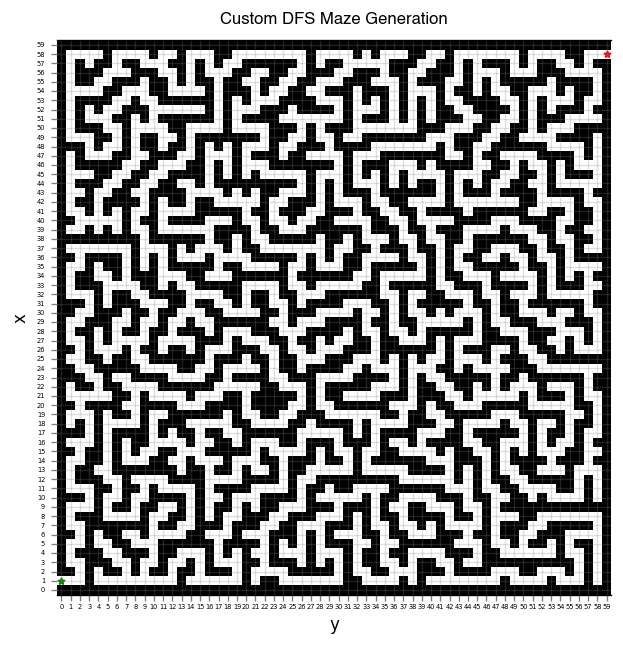

In [11]:
# Building the maze
maze.build_maze() 
# Plotting the maze
maze.plot_maze() 

In [12]:
# Exporting the grid (for future solvers)
maze.get_grid_values(export=True); # Supressing output

---